# Pynkowski for Temperature maps

In this notebook, we can find a small example of how to use the `Pynkowski` package in order to compute the Minkowski Functional of a scalar HEALPix map

In [1]:
import sys 
sys.path.insert(0, "/home/javier/data/work/pynkowski/pynkowski/")
import pynkowski as mf
mf.__file__

'/home/javier/data/work/pynkowski/pynkowski/pynkowski/__init__.py'

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import pynkowski as mf   # For Minkowski Functionals

## Input map

You can use any scalar healpy map such as the Planck temperature maps. In order to make this notebook reproducible without external data, we create a sample map with a simple power spectrum. The only condition (for the second and third MFs) is that it has to be reasonably smooth: the `nside` parameter must be large enough (or `lmax` small enough) for the spatial derivatives to exist. If the results are too noisy, this could be the problem.

In [3]:
nside = 512
ell = np.arange(3*nside - 1)
c_ell = np.exp(-(ell-100)**2 / 5000)

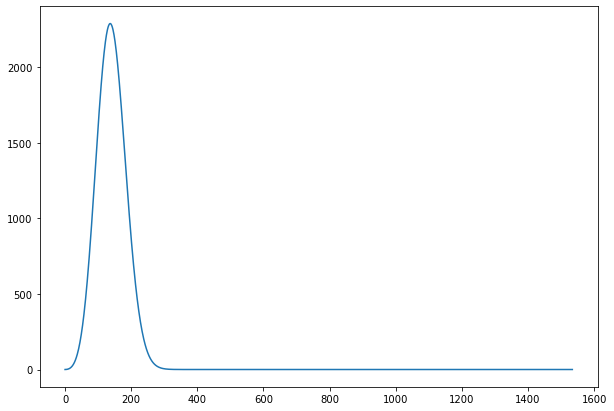

In [4]:
plt.figure(figsize=(10,7))
plt.plot(ell, c_ell*ell*(ell+1)/(2.*np.pi))

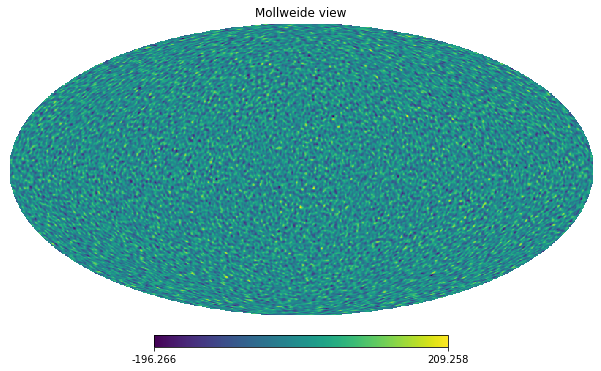

In [5]:
tmap = hp.synfast(c_ell, nside)
hp.mollview(tmap)

## Thresholds and scalar map

We set a uniform set of thresholds from -5σ to 5σ.

In [6]:
us = np.arange(-5., 5.01, 0.1)

And we create a `Scalar` object that will store the map and its derivatives, and will compute the MFs:

In [7]:
data = mf.Healpix(tmap, normalise=True, mask=None)     # Default parameters

<details><summary>Information about settings</summary>
    
We use the default settings:
 - `normalise = True`, this divides the map over the σ in such a way that we can work with adimensional `us`. Otherwise the thresholds have to be defined in an appropiate range for the given maps
 - `mask = None`, as we do not have a mask. If a mask is given, the MFs are computed only within the mask (where mask=True). However, the spatial derivatives are always computed full sky in order to avoid numerical errors, so we recommend using inpainted maps or removing singularities on the maps.

## Computation of MFs

The 3 MFs can be now computed with:

In [8]:
v0 = mf.V0(data, us)
v1 = mf.V1(data, us)
v2 = mf.V2(data, us)

100%|██████████| 101/101 [00:03<00:00, 31.68it/s]


<details><summary>Information about derivatives</summary>
Before computing v1 and v2, we have to compute the first and second derivatives of the map, respectively. This is automatically done a single time upon calling and they are then stored. If one wants to compute them beforehand, it can be done with `Map.get_second_der()` (or `Map.get_first_der()` if one wants only the first derivatives).

## Computation of the Gaussian isotropic predictions

We create an instance of `TheoryTemperature`. This has two functions: it provides the theoretical formulae, and it averages the value within each threshold bin in order to provide a faithful comparison.

In [9]:
# Option 1  (preferred)
theo = mf.SphericalGaussian(cls=c_ell, normalise=True, fsky=1.)   # Default parameters

# Option 2   (any of the definitions of mu, then the definition of theo)
# mu = mf.theory.utils_th.get_μ(c_ell)
# mu = ((data.first_der[0]**2.) + (data.first_der[1]**2.))/2.
# theo = mf.Gaussian(dim=2, sigma=1., mu=mu, lkc_ambient=[0., 0., 4.*np.pi])

In [10]:
v0t = mf.V0(theo, us)
v1t = mf.V1(theo, us)
v2t = mf.V2(theo, us)

## Visualization

In [11]:
def plot_V(us, v, v_theo, i='0'):
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(14,10), gridspec_kw={'height_ratios':[3,1]})
    axs[0].plot(us, v_theo, 'k--', label='Theory')
    axs[0].plot(us, v, '.', label='Map', color='C1')
    axs[0].set_ylabel(f'v{i}', size=17)
    axs[0].legend()

    axs[1].plot(us, v*0, 'k--', label='Theory')
    axs[1].plot(us, v-v_theo, '.', label='Map', color='C1')
    plt.legend()
    plt.xlabel('u', size=17)
    plt.ylabel(f'Δv{i}', size=17)
    fig.subplots_adjust(hspace=0)

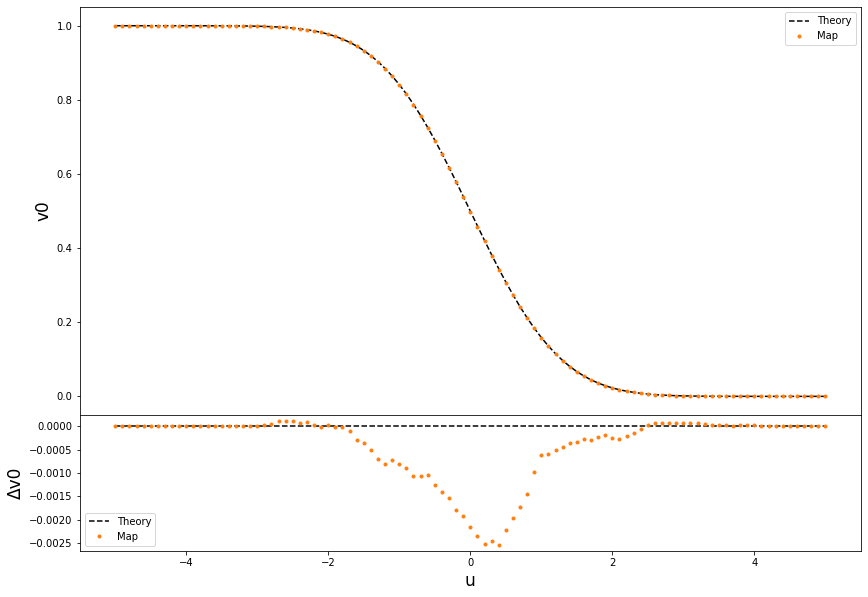

In [12]:
plot_V(us, v0, v0t, '0')

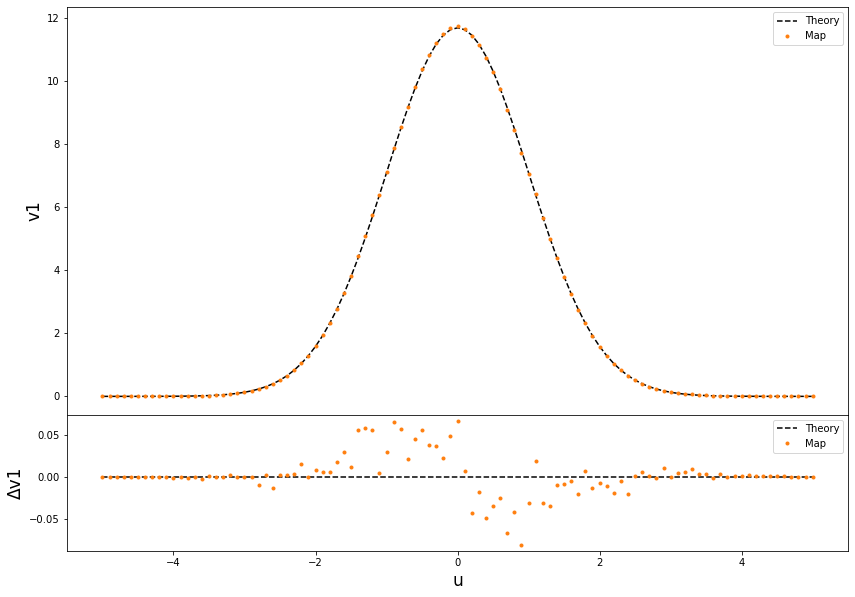

In [13]:
plot_V(us, v1, v1t, '1')

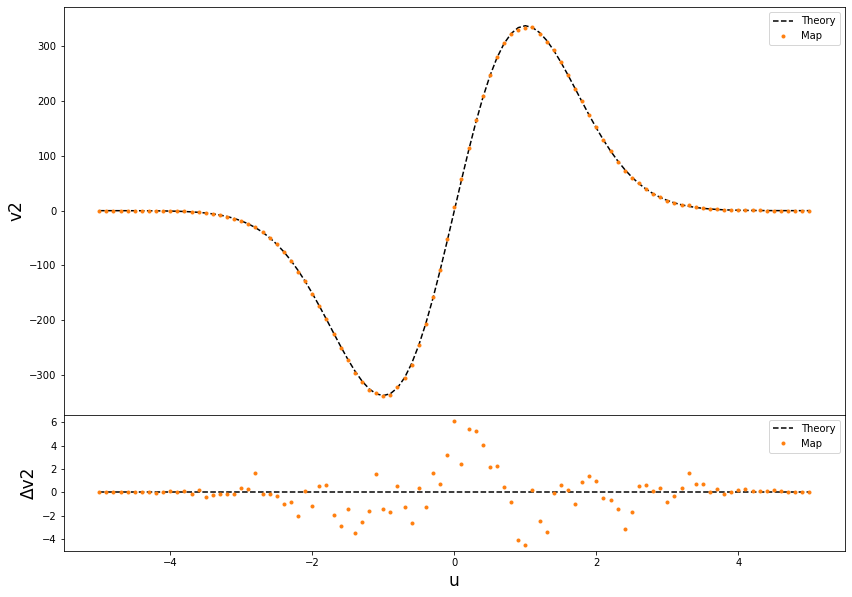

In [14]:
plot_V(us, v2, v2t, '2')

We can see that the three MFs are remarkably close to the theoretical prediction, as we are analysing a Gaussian isotropic map (because it was produced by `hp.synfast`).

`Pynkowski` has been created by Javier Carrón Duque and Alessandro Carones.

The repository can be found on https://github.com/javicarron/pynkowski

The documentation can be found on https://javicarron.github.io/pynkowski